In [1]:
!pip install gym

In [2]:
import gym
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [4]:
env = gym.make('CartPole-v1')
env._max_episode_steps=1000
print(f'에피소드 종료까지 최대 상한 스텝: {env._max_episode_steps}')

에피소드 종료까지 최대 상한 스텝: 1000


/home/hshwang/anaconda3/envs/torch_1.8/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [5]:
help(env.unwrapped)

Help on CartPoleEnv in module gym.envs.classic_control.cartpole object:

class CartPoleEnv(gym.core.Env)
 |  CartPoleEnv(*args, **kwds)
 |  
 |  ### Description
 |  
 |  This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in
 |  ["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077).
 |  A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track.
 |  The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces
 |   in the left and right direction on the cart.
 |  
 |  ### Action Space
 |  
 |  The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction
 |   of the fixed force the cart is pushed with.
 |  
 |  | Num | Action                 |
 |  |-----|------------------------|
 |  | 0   | Push cart to the left  |
 |  | 1   | Push cart to the righ

In [6]:
state = env.reset()
n_state = state.shape[0]
n_action = env.action_space.n
print(f'관찰의 차원: {n_state}')
print(f'취할 수 있는 행동: {n_action}')

관찰의 차원: 4
취할 수 있는 행동: 2


In [7]:
class NN_model(nn.Module):
    def __init__(self,input_dim=n_state,output_dim=n_action):
        super(NN_model,self).__init__()
        '''
        입력변수
            input_dim: state의 차원 -> cartpole [위치, 속도, 각도, 각속도]
            output_dim: action의 차원 -> cartpole [왼쪽, 오른쪽]
                        critic의 차원 -> 1
        N.N 구조
            4 layer구조 (2 hidden layer).
            hidden node개수는 64개로 통일.
            activation function은 Relu 설정
        '''
        self.lin1 = nn.Linear(input_dim,64)
        self.lin2 = nn.Linear(64,64)
        self.policy_out = nn.Linear(64,output_dim)
        self.value_out = nn.Linear(64,1)
        
    def forward(self,x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        policy = self.policy_out(x)
        value = self.value_out(x).squeeze(dim=-1)
        return policy, value
    
    def get_action(self,x):
        if x.shape == 1:
            x = torch.FloatTensor(x[None]).to(device)
        else:
            x = torch.FloatTensor(x).to(device)
        policy,_ = self.forward(x)
        policy = F.softmax(policy,dim=-1).detach().cpu().numpy().ravel()
        actions = np.random.choice(n_action, p=policy) 
        return actions

In [9]:
agent=NN_model()

In [10]:
def A2C_loss(state,action,rewards,next_state,done,gamma=0.99,agent=agent):
    '''
    목적: A2C loss계산후 agent 학습
        목적함수: -log(policy)*value + (value_infer-value_target)**2 + policy*log(policy)
            "-log(policy)*value": Actor-loss(exploitation)
            "policy*log(policy)": Actor-entropy(exploration)
            "(value_infer-value_target)**2": Critic-loss
    입력인자
        state: 상태 [1,4]
        action: 액션 [1,2]
        rewards: 보상 - TD step에 따라 step의 수가 정해져 있음 [TD_step]
        next_state: 다음상태 [1,4]
        done: 종료여부 
        gamma: discount factor(할인율)
        agent: agent
    출력인자
        total_loss: 모니터링을 위한 total_loss
    '''
    def Calculate_target(rewards,gamma):
        '''
        목표
            G_t = R_{t+1}+gamma*R_{t+2}+gamma**2+R_{t+3}+...
        '''
        returns = rewards[-1] 
        for reward in reversed(rewards[:-1]):
            returns = gamma*returns+reward
        return returns.view(-1,)
    
    states = torch.FloatTensor(state).to(device)
    actions = torch.LongTensor(action).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_state).to(device)
    dones = torch.tensor(done,dtype=torch.uint8).to(device)
    
    policy,value = agent(states)
    next_policy,next_value = agent(next_states)
    
    probs = F.softmax(policy,dim=-1)
    logprobs = F.log_softmax(policy,dim=-1)
    next_value[done] = 0.
    
    target_value = Calculate_target(rewards,gamma)
    advantage = target_value-value
    
    logp_actions = logprobs[np.arange(states.shape[0]),actions]
    
    entropy = -probs*logprobs
    actor_loss = -(logp_actions*advantage.detach()).mean()-0.001*entropy.mean()
    critic_loss = F.mse_loss(target_value.detach(),value)
    total_loss = actor_loss + critic_loss
    
    return total_loss

In [27]:
def MC_play_or_train_agent(env,agent,optimizer,train=True):
    '''
    목표: agent를 환경에 맞게 train할것인지 단순 play할것인지 구성
    입력인자
        env: environment(CartPole)
        agent: agnet
        train: 학습여부(True: 학습, False: play)
        TD_step: TemporalDifference(0) -> MonteCarlo(-1)
    출력인자
        total_reward: 
        loss: 모니터링을 위한 TD error의 추이
    '''
    
    total_reward = 0
    
    state_1st = env.reset()    
    state = state_1st.copy()
    rewards = []
    while True:
        action = agent.get_action(state)
        new_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        total_reward += reward
        state = new_state
        if done:
            break
    if train:
        optimizer.zero_grad()
        loss = A2C_loss([state_1st],[action],rewards,[new_state],[done],agent=agent)
        loss.backward()
        optimizer.step()
      
    if train:
        return total_reward, loss.item()
    else:
        return None

In [41]:
def TD_play_or_train_agent(env,agent,optimizer,train=True,TD_step=0):
    '''
    목표: agent를 환경에 맞게 train할것인지 단순 play할것인지 구성
    입력인자
        env: environment(CartPole)
        agent: agnet
        train: 학습여부(True: 학습, False: play)
        TD_step: TemporalDifference(0) -> MonteCarlo(-1)
    출력인자
        total_reward: 
        loss: 모니터링을 위한 TD error의 추이
    '''
    
    total_reward = 0
    state_1st = env.reset()
    s = state_1st.copy()
    rewards = []
    cnt = 0
    while True:
        cnt += 1
        action = agent.get_action(s)

        new_s, reward, done, _ = env.step(action)
        rewards.append(reward)
        total_reward += reward
        
        if train and cnt % (TD_step+1) == 0:
            optimizer.zero_grad()
            loss = A2C_loss([state_1st],[action],rewards,[new_s],[done],agent=agent)
            loss.backward()
            optimizer.step()
            state_1st = new_s.copy()
        s = new_s.copy()
        if done:
            break
    if train:
        return total_reward, loss.item()
    else:
        return None

Episode 499


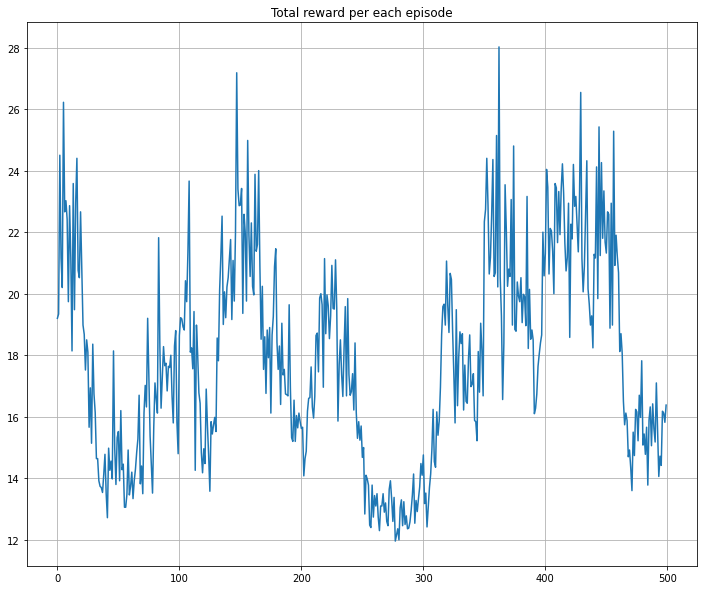

100%|█████████████████████████████████████████████████████████████████| 500/500 [05:00<00:00,  1.66it/s]


In [33]:
from tqdm import trange
from IPython.display import clear_output

agent = NN_model().to(device)
optimizer = optim.Adam(agent.parameters(),lr=1e-04)

A2C_losses = []
episode_rewards = []
max_episodes = 500
mini_sessions = 50

for episode in trange(max_episodes):
    mini_reward = []
    for mini_session in range(mini_sessions):
        episode_reward, total_loss = MC_play_or_train_agent(env,agent=agent,optimizer=optimizer,train=True)
        mini_reward.append(episode_reward)
    
    episode_rewards.append(np.mean(mini_reward))
    A2C_losses.append(np.mean(total_loss))
    
    clear_output(True)
    print("Episode",episode)
    
    plt.figure(figsize=[12, 10])
    plt.title("Total reward per each episode")
    plt.plot(episode_rewards)
    plt.grid()
    plt.show()
    
    if np.mean(mini_reward) >= 500:
        print(f"Agent finds solution! Final score : {np.mean(mini_reward)}")
        break

Episode 12


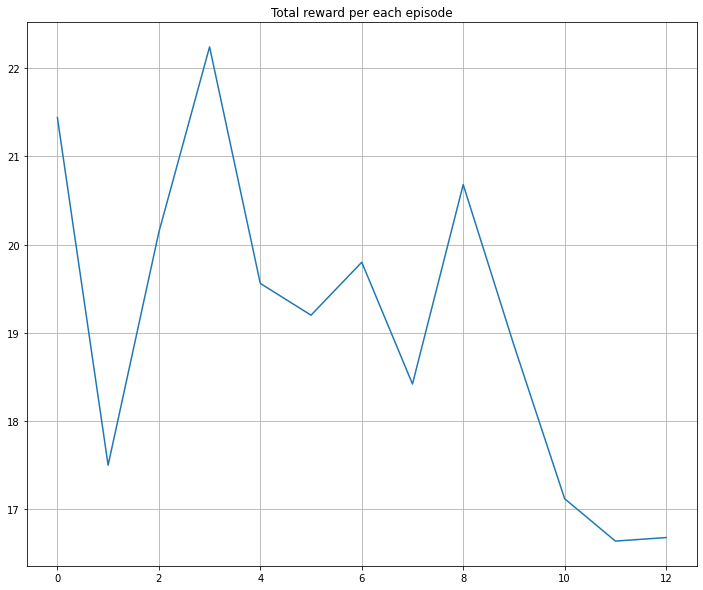

  3%|█▋                                                                | 13/500 [00:59<36:55,  4.55s/it]


KeyboardInterrupt: 

In [48]:
agent = NN_model().to(device)
optimizer = optim.Adam(agent.parameters(),lr=1e-04)

A2C_losses = []
episode_rewards = []
max_episodes = 500
mini_sessions = 50

for episode in trange(max_episodes):
    mini_reward = []
    for mini_session in range(mini_sessions):
        episode_reward, total_loss = TD_play_or_train_agent(env,agent=agent,optimizer=optimizer,train=True)
        mini_reward.append(episode_reward)
    
    episode_rewards.append(np.mean(mini_reward))
    A2C_losses.append(np.mean(total_loss))
    
    clear_output(True)
    print("Episode",episode)
    
    plt.figure(figsize=[12, 10])
    plt.title("Total reward per each episode")
    plt.plot(episode_rewards)
    plt.grid()
    plt.show()
    
    if np.mean(mini_reward) >= 500:
        print(f"Agent finds solution! Final score : {np.mean(mini_reward)}")
        break

In [43]:
rewards = [1,2,3]
gamma = 0.9
answer = rewards[0]+gamma*rewards[1]+gamma**2*rewards[2]
print(answer)

5.23


In [44]:
def calculate_return(rewards,gamma=0.9):
    returns = rewards[-1]
    for ret in reversed(rewards[:-1]):
        returns = gamma*returns+ret
    return returns

In [45]:
print(calculate_return(rewards))

5.23
